In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [65]:
words = open("names.txt","r").read().splitlines()

In [66]:
chars = sorted(list(set("".join(words))))
stoi = { s:i+1 for i,s in enumerate(chars) }
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [77]:
block_size = 3
n1 = int(0.8 * len(words))
n2 = int(0.1 * len(words))
def build_dataset(words):
    X,Y = [],[]
    for w in words:
        #print(w)
        chars = "."*block_size + w + "." 
        for i in range(len(chars)-block_size):
            X.append([stoi[ix] for ix in chars[i:i+block_size]])
            Y.append(stoi[chars[i+block_size]])
            #print(f"{chars[i:i+n]} -> {chars[i+n]}")
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return(X,Y)
import random
random.shuffle(words)
Xtr , Ytr = build_dataset(words[:n1])
Xdev , Ydev = build_dataset(words[n1:n1+n2])
Xtest , Ytest = build_dataset(words[n1+n2:])

torch.Size([182511, 3]) torch.Size([182511])
torch.Size([22813, 3]) torch.Size([22813])
torch.Size([22822, 3]) torch.Size([22822])


In [105]:
n_hidden = 100
n_emb = 2
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
g = torch.Generator().manual_seed(21715050)
C = torch.randn((27,n_emb),generator=g)
W1 = torch.randn(((n_emb * block_size),n_hidden),generator=g) * 0.2
b1 = torch.randn((n_hidden),generator=g) *0.01
W2 = torch.randn((n_hidden,27),generator=g) * 0.01
b2 = torch.randn((27),generator=g) * 0.01
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
for p in parameters:
    p.requires_grad = True

In [108]:
batch_size = 32
max_steps = 3000
for i in range(max_steps):

    ix =  torch.randint(0,Xtr.shape[0],(batch_size,))    
    # forward pass
    emb = C[Xtr][ix] # (32,3,2)
    embcat = emb.view(-1,n_emb*block_size)
    hpreact = embcat @ W1 + b1
    hpreact =  bngain* (hpreact - hpreact.mean(0,keepdim=True))/ hpreact.std(0,keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # probs = counts / counts.sum(1,keepdim=True)
    # loss = -probs[torch.arange(32),Y].log().mean()
    loss = F.cross_entropy(logits,Ytr[ix])
    if(i % 100 == 0):
        print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i<2000 else 0.01
    for p in parameters:
        p.data += -0.007 * p.grad


2.6273841857910156
2.7433834075927734
2.8380520343780518
2.6460659503936768
2.844289541244507
2.7873127460479736
2.9730064868927
2.6482222080230713
2.5687053203582764
2.5275919437408447
2.7114365100860596
3.0328025817871094
2.5273687839508057
2.4105594158172607
2.8540399074554443
2.6271586418151855
2.580650568008423
2.5679709911346436
2.4741382598876953
2.7595698833465576
2.5418295860290527
2.845902681350708
2.4740662574768066
2.819683074951172
2.450183153152466
2.6271297931671143
2.5503485202789307
2.447953224182129
2.6877286434173584
2.634307622909546


(array([ 10.,  16.,  14.,  35.,  46.,  57.,  58.,  62.,  40.,  50.,  53.,
         65.,  77.,  73.,  94.,  91.,  73.,  67., 103., 105.,  98., 104.,
         83.,  74., 117.,  96., 120., 105.,  92., 100.,  86.,  95.,  53.,
         74.,  72.,  75.,  75.,  58.,  76.,  39.,  52.,  51.,  48.,  49.,
         32.,  18.,  24.,  25.,  12.,   8.]),
 array([-0.94490361, -0.90720687, -0.86951013, -0.83181339, -0.79411665,
        -0.75641991, -0.71872318, -0.68102644, -0.6433297 , -0.60563296,
        -0.56793622, -0.53023948, -0.49254274, -0.454846  , -0.41714926,
        -0.37945252, -0.34175578, -0.30405904, -0.2663623 , -0.22866556,
        -0.19096882, -0.15327208, -0.11557534, -0.07787861, -0.04018187,
        -0.00248513,  0.03521161,  0.07290835,  0.11060509,  0.14830183,
         0.18599857,  0.22369531,  0.26139205,  0.29908879,  0.33678553,
         0.37448227,  0.41217901,  0.44987575,  0.48757249,  0.52526923,
         0.56296597,  0.6006627 ,  0.63835944,  0.67605618,  0.71375292,
 

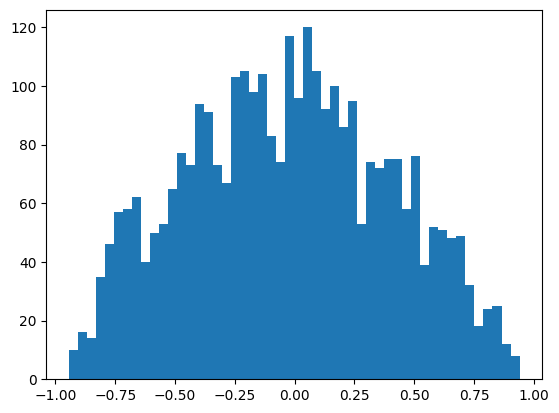

In [87]:
plt.hist(h.view(-1).tolist(),50)

In [110]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(-1,n_emb*block_size)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [111]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr,Ytr),
        "val": (Xdev,Ydev),
        "test":(Xtest,Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(-1,n_emb*block_size)
    hpreact = embcat @ W1 + b1
    hpreact =  bngain* (hpreact - bnmean)/ (bnstd+0.01) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split , loss.item())
split_loss("train")
split_loss("val")

train 2.6270530223846436
val 2.629551887512207


Original:
train 2.71
val 2.705
fix softmax initializations:
train 2.5763285160064697
val 2.5684869289398193

In [ ]:
for _ in range(20):    
    out = []
    context = [0]*block_size
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if(ix == 0):
            break
    print("".join([itos[i] for i in out]))


In [61]:
w = torch.empty(3,5)
torch.nn.init.kaiming_normal_(w,mode='fan_in')

tensor([[ 0.7108,  0.1226,  0.0958, -0.2214,  1.1474],
        [ 0.3368,  0.0491,  0.0233, -0.2686, -0.6203],
        [ 0.8205,  0.5875, -0.4193, -0.0729,  0.0642]])

In [113]:
from typing import Any


class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weights = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_in) if bias else None
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias:
            self.out += self.bias
        return self.out
    def parameters(self):
        return([self.weights] + ([] if self.bias is None else [self.bias]))
class BatchNoram1d:
    def __init__(self,dim,eps=1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self, x ):
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.std(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
          with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return([self.gamma,self.beta])
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters():
        return []
  

In [ ]:
n_emb = 2
vocab_size = 27
n_hidden = 100
C = torch.randn((vocab_size,n_emb))
layers = [
    Linear(n_emb*block_size , n_hidden,False) , BatchNoram1d(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden,False) , BatchNoram1d(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden,False) , BatchNoram1d(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden,False) , BatchNoram1d(n_hidden) , Tanh(),
    Linear(n_hidden , vocab_size) , BatchNoram1d(n_hidden)
]

parameters =[C] + [p for l in layers for p in l.parameters()]
for p in parameters:
    p.requires_grad = True

In [ ]:
max_steps = 5000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb , Yb = Xtr[ix] , Ytr[ix]
    emb = C[Xb]
    x = emb.view(-1,block_size*n_emb)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb)

    for p in parameters:
        p.grad = None
    loss.backward
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

In [ ]:
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(-1,block_size*n_emb)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits)
        ix = torch.multinomial(probs,1).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if(ix == 0):
            break
    print("".join([out]))

In [4]:
import torch 
w = torch.rand(10)
a = torch.randn((4,10))
k = a + w
k.shape

torch.Size([4, 10])